**Linear Regression using Polars**

IMPORTS

In [13]:
import polars as pl
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [14]:
# Timing helper function
def time_function(func, func_name=''):
    start_time = time.time()
    result = func()
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"{func_name} took {elapsed_time:.4f} seconds")
    return result

In [15]:
# Function to load and prepare data
def load_data(file_path):
    try:
        data = pl.read_csv(
            file_path,
            ignore_errors=True,
        )
        print("Data loaded successfully!")
        return data
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None

In [16]:
# Convert categorical columns to numeric
def convert_categorical(data):
    # List of categorical columns to convert
    categorical_columns = ['Neighborhood']  # Add other categorical columns as needed
    for col in categorical_columns:
        data = data.with_columns(pl.col(col).cast(pl.Utf8).cast(pl.Categorical))  # Convert to categorical
    return data


In [17]:
# Function to select features and target variable
def prepare_data(data):
    X = data.select(['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath']).to_numpy()
    y = data['SalePrice'].to_numpy()
    return X, y

In [18]:
# Function to train the model
def train_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

In [19]:
# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'R-squared: {r2:.2f}')
    
    return y_pred

# Function for predicting the price of a house
def predict_house_price(model, features):
    predicted_price = model.predict(features)
    return predicted_price

In [20]:
# Function for plotting the results
def plot_results(X_test, y_test, y_pred, model):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test[:, 0], y_test, color='blue', label='Actual Prices', alpha=0.5)  # Actual Prices
    plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted Prices', alpha=0.5)  # Predicted Prices

    # Create a range of values for GrLivArea for the prediction line
    gr_liv_area_range = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100).reshape(-1, 1)

    # Prepare the input for predictions by combining with other feature means
    mean_features = np.mean(X_test, axis=0)[1:]  # Get the means of BedroomAbvGr, FullBath, HalfBath
    mean_features = np.append(gr_liv_area_range, np.tile(mean_features, (gr_liv_area_range.shape[0], 1)), axis=1)

    # Get predictions for the prediction line
    predicted_line = model.predict(mean_features)

    # Plot the prediction line
    plt.plot(gr_liv_area_range, predicted_line, color='green', linewidth=2, label='Prediction Line')

    plt.title('House Price Prediction')
    plt.xlabel('Ground Living Area (sq ft)')
    plt.ylabel('Sale Price')
    plt.legend()
    plt.grid()
    plt.show()

In [21]:
# Main execution
train_file_path = 'D:/MY PROJECTS/internship3/Task1/Data1/train.csv'
test_file_path = 'D:/MY PROJECTS/internship3/Task1/Data1/test.csv'  # Add path to your test.csv


Data loaded successfully!
Loading Training Data took 0.0076 seconds
Preparing Training Data took 0.0000 seconds
Training the Model took 0.0090 seconds
Mean Squared Error: 2810942965.22
Mean Absolute Error: 36018.56
R-squared: 0.63
Evaluating the Model took 0.0000 seconds
Data loaded successfully!
Loading Test Data took 0.0000 seconds
Predicting House Prices took 0.0000 seconds
shape: (5, 2)
┌─────────────┬─────────────────┐
│ House_Index ┆ Predicted_Price │
│ ---         ┆ ---             │
│ i32         ┆ f64             │
╞═════════════╪═════════════════╡
│ 1           ┆ 121423.030985   │
│ 2           ┆ 143380.870622   │
│ 3           ┆ 204748.668874   │
│ 4           ┆ 202205.354725   │
│ 5           ┆ 191336.364775   │
└─────────────┴─────────────────┘


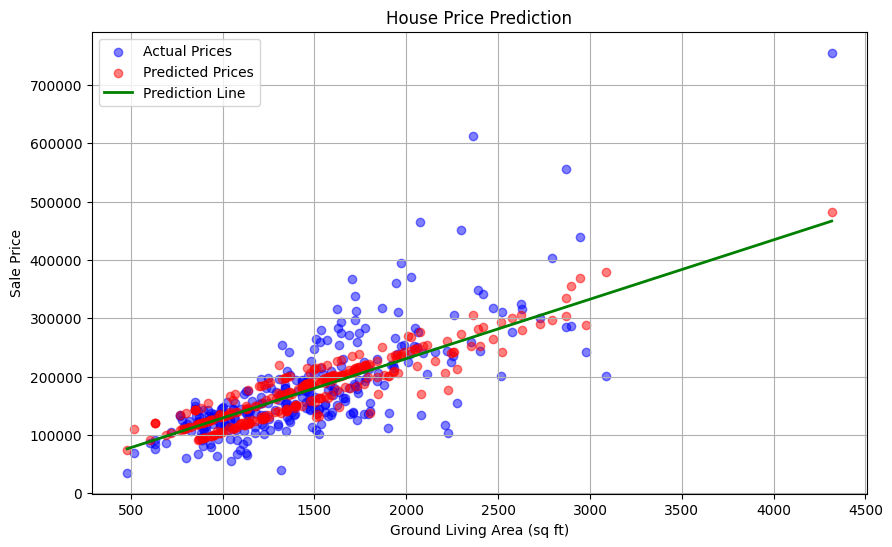

Plotting Results took 0.1317 seconds


In [22]:
# Load and prepare the training data
train_data = time_function(lambda: load_data(train_file_path), 'Loading Training Data')  # Load the training data
if train_data is not None:
    
    # Prepare training data
    X_train, y_train = time_function(lambda: prepare_data(train_data), 'Preparing Training Data')  # Prepare the data for training

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Train the model
    model = time_function(lambda: train_model(X_train, y_train), 'Training the Model')  # Train the linear regression model

    # Evaluate the model
    y_pred = time_function(lambda: evaluate_model(model, X_test, y_test), 'Evaluating the Model')  # Evaluate model performance

    # Load the test data for prediction
    test_data = time_function(lambda: load_data(test_file_path), 'Loading Test Data')  # Load the test data
    if test_data is not None:
        # Prepare test data for prediction
        example_features = test_data.select(['GrLivArea', 'BedroomAbvGr', 'FullBath', 'HalfBath']).to_numpy()

        # Make predictions for the loaded test data
        predicted_prices = time_function(lambda: predict_house_price(model, example_features), 'Predicting House Prices')  # Predict house prices
        
        # Create a Polars DataFrame for the predicted prices
        predicted_prices_df = pl.DataFrame({
            'House_Index': np.arange(1, len(predicted_prices) + 1),  # Add an index for reference
            'Predicted_Price': predicted_prices
        })

        # Save the predicted prices to a CSV file
        output_file_path = 'D:/MY PROJECTS/internship3/Task1/Data1/predicted_prices.csv'
        predicted_prices_df.write_csv(output_file_path)

        # Show the head of the DataFrame
        print(predicted_prices_df.head())  # Display the first few rows of predicted prices

    # Plot results
    time_function(lambda: plot_results(X_test, y_test, y_pred, model), 'Plotting Results')  # Plot the results of the model

In [23]:
print(train_data.dtypes)
print(train_data.head())  # View the first few rows to identify categorical values


[Int64, Int64, String, String, Int64, String, String, String, String, String, String, String, String, String, String, String, String, Int64, Int64, Int64, Int64, String, String, String, String, String, Int64, String, String, String, String, String, String, String, Int64, String, Int64, Int64, Int64, String, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, String, Int64, String, Int64, String, String, String, String, Int64, Int64, String, String, String, Int64, Int64, Int64, Int64, Int64, Int64, String, String, String, Int64, Int64, Int64, String, String, Int64]
shape: (5, 81)
┌─────┬────────────┬──────────┬─────────────┬───┬────────┬──────────┬───────────────┬───────────┐
│ Id  ┆ MSSubClass ┆ MSZoning ┆ LotFrontage ┆ … ┆ YrSold ┆ SaleType ┆ SaleCondition ┆ SalePrice │
│ --- ┆ ---        ┆ ---      ┆ ---         ┆   ┆ ---    ┆ ---      ┆ ---           ┆ ---       │
│ i64 ┆ i64        ┆ str      ┆ str         ┆   ┆ i64    ┆ str      ┆ str     

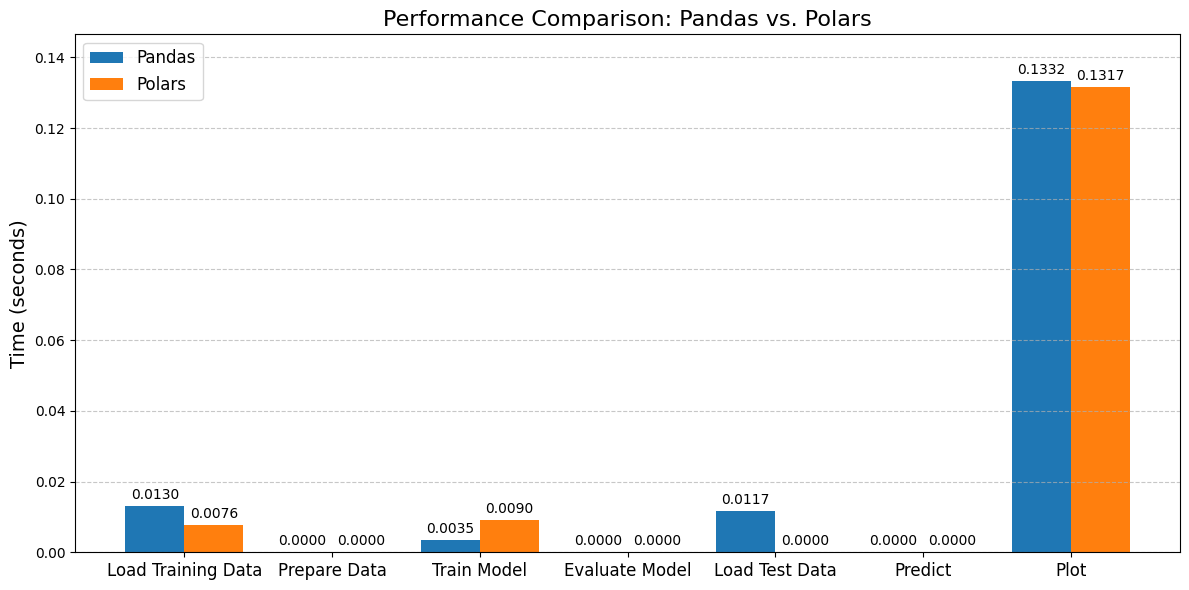

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Corrected Metrics
metrics = ['Load Training Data', 'Prepare Data', 'Train Model', 'Evaluate Model', 'Load Test Data', 'Predict', 'Plot']
pandas_times = [0.0130, 0.0000, 0.0035, 0.0000, 0.0117, 0.0000, 0.1332]
polars_times = [0.0076, 0.0000, 0.0090, 0.0000, 0.0000, 0.0000, 0.1317]

x = np.arange(len(metrics))  # the label locations
width = 0.4  # the width of the bars

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))  # Wider figure
rects1 = ax.bar(x - width/2, pandas_times, width, label='Pandas', color='#1f77b4')  # Blue
rects2 = ax.bar(x + width/2, polars_times, width, label='Polars', color='#ff7f0e')  # Orange

# Add grid lines
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Add labels and title with adjusted font sizes
ax.set_ylabel('Time (seconds)', fontsize=14)
ax.set_title('Performance Comparison: Pandas vs. Polars', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)

# Show value on top of bars with adjusted font size
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)

# Set limits for y-axis for better visibility
ax.set_ylim(0, max(max(pandas_times), max(polars_times)) * 1.1)

# Show the plot
plt.tight_layout()
plt.show()
